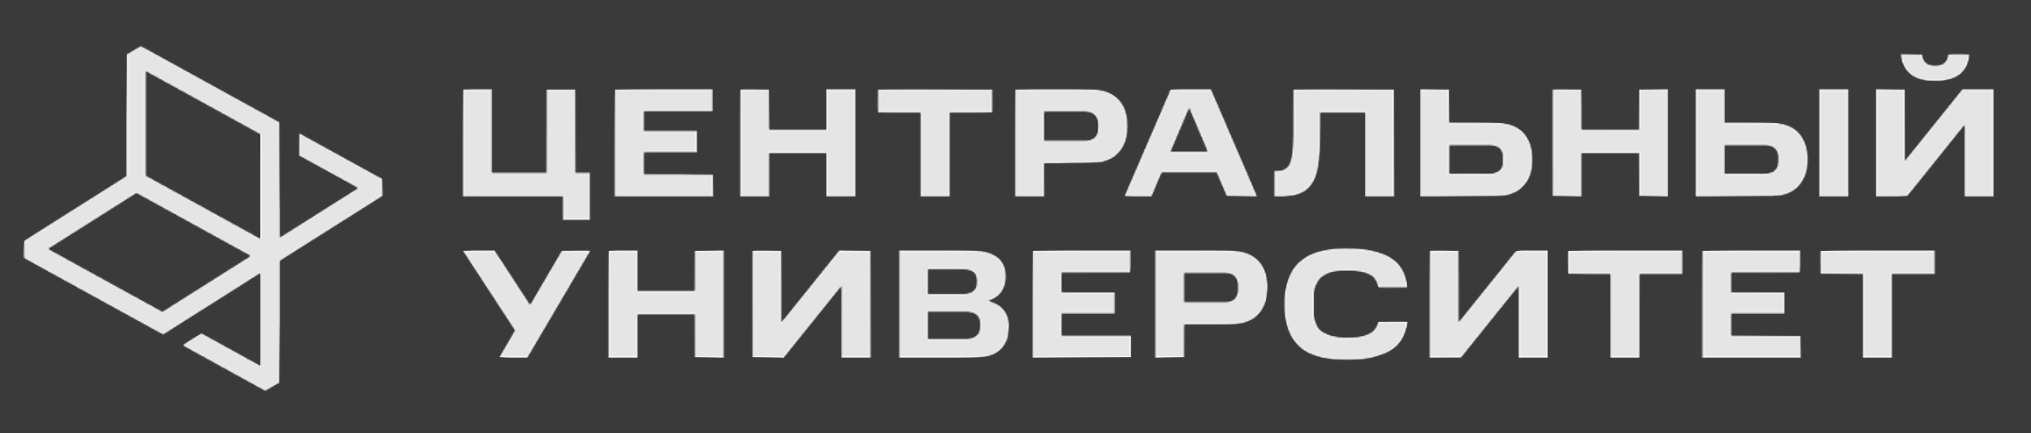

# Семинар 8. Generative models.

## Plan:
0. Data preparation
1. Autoencoders
    - Vanilla AE
    - Denoising Autoencoder(DAE)
    - Variational Autoencoder(VAE)
        - KL divergence
        - ELBO
        - reparametrization trick
        - implementation
2. GANs
    - DCGAN Architecture
    - training with GAN objective
    
3. Generation quality assessment
    - IS
    - FID
    - LPIPS

___

# 2. GANs

Vanilla **GAN** uses linear layers to encode/decode features

It worth mentioning that we could have implemented all **AE**s using convolutional networks.

Let's use them here

So we will have slightly different form vanilla architecture, called **D**eep **C**onvolution **GAN**(**DCGAN**)

![](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*t82vgL9KcDVpT4JqCb9Q4Q.png)

## 2.1 DCGAN architecture

In [ ]:
import torch.nn as nn
import torch

In [ ]:
class DisBlock(nn.Module):
    def __init__(
        self, in_channels=None, out_channels=None,
        kernel_size=None, padding=0, stride=1,
        last_layer=False, first_layer=False
        ):
        """
        Discriminator block
        """
        super().__init__()

        # stride == N allows us for compress image by N
        # compensate with pad for kernel size
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=4 if not last_layer else 1,
            padding=1 if not last_layer else 0,
            bias=first_layer or last_layer, # as far as we switch off BN and activation,
            stride=stride
        )
        self.act = nn.LeakyReLU(0.2, inplace=True)

        # cancel bias term in case that we have it in convolution
        self.norm = nn.BatchNorm2d(
            num_features=out_channels
        ) if not (first_layer or last_layer) else None

        self.last_layer = last_layer
        self.first_layer = first_layer

    def forward(self, x):

        x = self.conv(x)

        if self.first_layer:
            x = self.act(x)
        elif not self.last_layer:
            x = self.act(self.norm(x))

        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, latent_dim=64, num_filters=64, im_dim=None, num_channels=1):
        """
        classify image batch: BxCx{im_dim}x{im_dim}
        outputs: Bx1
        """
        super().__init__()

        self.blocks = nn.Sequential(
            # BxCx{im_dim}x{im_dim}=64
            DisBlock(
                in_channels=num_channels,
                out_channels=num_filters,
                stride=2, # downsample via stride
                first_layer=True
            ),
            # Bx{num_filters}x32x32
            DisBlock(
                in_channels=num_filters,
                out_channels=num_filters * 2,
                stride=2 # downsample via stride
            ),
            # Bx{2xnum_filters}x16x16
            DisBlock(
                in_channels=num_filters * 2,
                out_channels=num_filters * 4,
                stride=2 # downsample via stride
            ),
            # Bx{4xnum_filters}x8x8
            DisBlock(
                in_channels=num_filters * 4,
                out_channels=num_filters * 8,
                stride=2 # downsample via stride
            ),
            # Bx{8xnum_filters}x4x4
            DisBlock(
                in_channels=num_filters * 8,
                out_channels=num_filters * 16,
                stride=2 # downsample via stride
            ),
            # Bx{16xnum_filters}x2x2
            DisBlock(
                in_channels=num_filters * 16,
                out_channels=1,
                stride=2, # downsample via stride
                last_layer=True
            )
            # Bx1x1x1
        )

        self.latent_dim = latent_dim
        self.im_dim = im_dim
        self.num_filters = num_filters

    def forward(self, x):

        # BxCx{im_dim}x{im_dim}=64 -> Bx1
        B = x.shape[0]
        x = self.blocks(x)

        return x.reshape(B, 1)

In [ ]:
batch_logits = Discriminator(im_dim=28)(torch.randn(10, 1, 64, 64))

print(batch_logits.shape)

batch_logits

torch.Size([10, 1])


tensor([[0.4121],
        [0.4712],
        [0.6877],
        [0.3676],
        [0.5559],
        [0.0825],
        [0.9727],
        [0.1194],
        [0.2855],
        [0.6854]], grad_fn=<ViewBackward0>)

In [ ]:
class GenBlock(nn.Module):
    def __init__(
        self, in_channels=None, out_channels=None,
        kernel_size=None, padding=0, stride=1, upsample_layer=None,
        last_layer=False, first_layer=False
        ):
        """
        Generator upsampling block
        """
        super().__init__()

        self.conv = upsample_layer(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=kernel_size, padding=padding, stride=stride,
            bias=first_layer or last_layer
        )
        self.act = nn.ReLU(inplace=True)

        # cancel bias term in case that we have it in convolution
        self.norm = nn.BatchNorm2d(
            num_features=out_channels
        ) if not (first_layer or last_layer) else None

        self.last_layer = last_layer
        self.first_layer = first_layer

    def forward(self, x):

        x = self.conv(x)

        if self.first_layer:
            x = self.act(x)
        elif not self.last_layer:
            x = self.act(self.norm(x))

        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=64, num_filters=64, upsample_layer=None, im_dim=None, num_channels=1):
        """
        recontructs noise batch: Bx{latent_dim}x1x1
        into image BxCx{im_dim}x{im_dim}
        """
        super().__init__()

        self.blocks = nn.Sequential(
            # Bx{latent_dim}x1x1
            GenBlock(
                upsample_layer=upsample_layer,
                in_channels=latent_dim,
                out_channels=16*num_filters,
                kernel_size=4, # oposite to stride in nn.Conv2d
                padding=1,
                stride=2,
                first_layer=True
            ),
            # Bx{16*num_filters}x2x2
            # keep rest of params as in nn.Conv2d
            GenBlock(
                upsample_layer=upsample_layer,
                in_channels=16*num_filters,
                out_channels=8*num_filters,
                kernel_size=4,
                padding=1,
                stride=2
            ),
            # Bx{8xnum_filters}x4x4
            GenBlock(
                upsample_layer=upsample_layer,
                in_channels=8*num_filters,
                out_channels=4*num_filters,
                kernel_size=4,
                padding=1,
                stride=2
            ),
            # Bx{4xnum_filters}x8x8
            GenBlock(
                upsample_layer=upsample_layer,
                in_channels=4*num_filters,
                out_channels=2*num_filters,
                kernel_size=4,
                padding=1,
                stride=2
            ),
            # Bx{2xnum_filters}x16x16
            GenBlock(
                upsample_layer=upsample_layer,
                in_channels=2*num_filters,
                out_channels=num_filters,
                kernel_size=4,
                padding=1,
                stride=2
            ),
            # Bx{num_filters}x32x32
            GenBlock(
                upsample_layer=upsample_layer,
                in_channels=num_filters,
                out_channels=num_channels,
                kernel_size=4,
                padding=1,
                stride=2,
                last_layer=True
            ),
            nn.Tanh()
            # Bx{C}x{im_dim}x{im_dim}
        )

        self.latent_dim = latent_dim
        self.num_filters = num_filters

    def forward(self, batch_size, device='cpu'):

        x = torch.randn(batch_size, self.latent_dim, 1, 1).to(device)

        return self.blocks(x)

In [ ]:
gen_imgs = Generator(upsample_layer=nn.ConvTranspose2d)(batch_size=10)
gen_imgs.shape

torch.Size([10, 1, 64, 64])

___

### 2.1.1 Checkerboard artifacts

![](https://distill.pub/2016/deconv-checkerboard/thumbnail.jpg)

[Here](https://distill.pub/2016/deconv-checkerboard/) you can study the problem statement in details

General rule of thumb is to pick kernel size divisible by stride value while using Transposed Convolution: `nn.ConvTranspose2d`

OR

use `nn.Upsample` & `nn.Conv2d` instead

___

In [ ]:
import torchvision.transforms as TT

transforms = TT.Compose([
    TT.Resize(64),
    TT.ToTensor(),
    TT.Normalize(mean=0.5, std=0.5) # note that we removed flatten from AE
])

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [ ]:
from torchvision.datasets import MNIST

dataset = MNIST(root='.', train=True, transform=transforms, download=False)

In [ ]:
img, label = dataset[0]
img.shape, label

(torch.Size([1, 64, 64]), 5)

In [ ]:
modes_list = [
    'nearest',
    'bilinear',
    'bicubic'
]

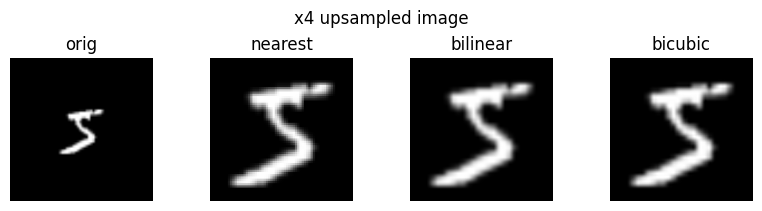

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=len(modes_list)+1, figsize=(8, 2), constrained_layout=True)

SCALE=4

for i in range(len(modes_list)+1):

    if i == 0:
        mode = 'orig'
        upsampled_img = F.pad(
            input=img,
            pad=tuple([28*(SCALE-1) // 2]*4),
            value=-1 # because we normalized in [-1, 1]
        )
    else:
        mode = modes_list[i-1]
        upsampled_img = F.interpolate(
            input=img.unsqueeze(0),
            scale_factor=SCALE,
            mode=mode
        )
    upsampled_img = (upsampled_img.clip(-1, 1) + 1) / 2

    axes[i].imshow(upsampled_img.squeeze(1).permute(1, 2, 0), cmap='gray')
    axes[i].set_title(mode)
    axes[i].axis('off')

fig.suptitle(f'x{SCALE} upsampled image')
plt.show()

---

## 2.3 training with GAN objective

### 2.3.1 Vanishing gradients

If the **Discriminator**(classifier) is smarter(learning to generalize better) the problem of vanishing gradient of **Generator** arises:

$$\min _G \mathbb{E}_{p(\mathbf{z})} \log (1-D(G(\mathbf{z})))$$

Instead let's reformulate:

$$\max _G \mathbb{E}_{p(\mathbf{z})} \log (D(G(\mathbf{z})))$$

Optimization task stays same, except for now, when **Discriminator** assigns low probability to generated sample, it's logarithm has high magnitude and the training continues

---

### 2.3.2 pipeline

### **GAN** objective
$$
\min _G \max _D V(G, D)=\min _G \max _D\left[\mathbb{E}_{\pi(\mathbf{x})} \log D(\mathbf{x})+\mathbb{E}_{p(\mathbf{z})} \log (1-D(G(\mathbf{z})))\right]
$$
- Generator: generative model $\mathbf{x}=G(\mathbf{z})$, which makes generated sample more realistic.
- Discriminator: a classifier $D(\mathbf{x}) \in[0,1]$, which distinguishes real samples from generated samples.

We use **B**inary **c**ross-**e**ntropy(**BCE**) as a loss function

in practice instead of:
$$\min _G \mathbb{E}_{p(\mathbf{z})} \log (1-D(G(\mathbf{z})))$$

$$\max _G \mathbb{E}_{p(\mathbf{z})} \log (D(G(\mathbf{z})))$$

is used to train $G$

### **Algorithm**:
1. **Discriminator**(*G* is frozen):
    - we take `B` **real** images and assign them the label 1
    - generate `B` **fake** images using a **G** and assign them the label 0
    - train the **D** to distinguish between the two classes `[0, 1]`: ("fake", "real")

2. **Generator**(*D* is frozen):
    - we generate `B` **fake** images with the **G** and assign them the label 1
    - predict with the **D** whether this image is real or not

3. Stopping criterion:
    - there is NO objective criterion for stopping the basic GAN training:
        - in Wasserstein GAN(WGAN) there is a distance, measuring difference of real and fake distributions
        - perceptual metrics are used to stop training once they stop to evolve(we'll see them in Section 3.)

[Here](https://poloclub.github.io/ganlab/) you can find interactive visualization on training procedure that might help in understanding

Now let's train our DCGAN!

In [ ]:
BATCH_SIZE = 64

# shuffle only during training
train_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

In [ ]:
from IPython.display import clear_output
from tqdm.notebook import tqdm
from torchvision.utils import make_grid

def train_gan(model=None, loader=None, optimizer=None, criterion=None, n_epochs=1, device=None, log_step=1):
    model['discriminator'].train()

    # log losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # for generation viz
    fixed_noise = torch.randn(25, model['generator'].latent_dim, 1, 1)

    for epoch_id in tqdm(range(n_epochs), desc='train loop', leave=True):

        # because we call .eval() for vizualization
        model['generator'].train()

        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []

        for real_images, _ in tqdm(loader, desc='batch iterations', leave=False):

            real_images = real_images.to(device)
            B = real_images.shape[0]

            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ## clear D gradients
            optimizer['discriminator'].zero_grad()

            ## pass real images through D

            real_preds = model['discriminator'](real_images)
            real_targets = torch.ones(B, 1, device=device)
            real_loss = criterion['discriminator'](real_preds, real_targets*0.9)
            real_loss.backward()
            torch.nn.utils.clip_grad_norm_(model['discriminator'].parameters(), max_norm=10.)

            cur_real_score = torch.mean(torch.sigmoid(real_preds)).item()

            ## generate fake images

            fake_images = model['generator'](batch_size=B, device=device)

            ## pass fake images through D

            fake_targets = torch.zeros(B, 1, device=device)
            fake_preds = model['discriminator'](fake_images.detach())
            fake_loss = criterion['discriminator'](fake_preds, fake_targets)
            fake_loss.backward()
            torch.nn.utils.clip_grad_norm_(model['discriminator'].parameters(), max_norm=10.)

            cur_fake_score = torch.mean(torch.sigmoid(fake_preds)).item()

            ## update D weights

            optimizer['discriminator'].step()
            loss_d = real_loss + fake_loss
            loss_d_per_epoch.append(loss_d.item())

            ## log D norm
            norm_d = torch.cat([
                param.grad.detach().flatten()
                for param in model['discriminator'].parameters()
                if param.grad is not None
            ]).norm().item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # (2) Update G network: maximize log(D(G(z)))
            ## Clear generator gradients
            optimizer['generator'].zero_grad()

            ## Generate fake images
            fake_images = model['generator'](batch_size=B, device=device)

            ## Try to fool the discriminator
            preds = model['discriminator'](fake_images)
            loss_g = criterion['generator'](preds, real_targets*0.9)

            loss_g.backward()
            torch.nn.utils.clip_grad_norm_(model['generator'].parameters(), max_norm=10.)

            # update generator weights
            optimizer['generator'].step()
            loss_g_per_epoch.append(loss_g.item())

            ## log G norm
            norm_g = torch.cat([
                param.grad.detach().flatten()
                for param in model['generator'].parameters()
                if param.grad is not None
            ]).norm().item()

            print(f'D L2 norm: {norm_d:.2f} \tG L2 norm: {norm_g:.2f}', end='\r')

        if epoch_id % log_step == 0:

            # Record losses & scores
            losses_g.append(np.mean(loss_g_per_epoch))
            losses_d.append(np.mean(loss_d_per_epoch))
            real_scores.append(np.mean(real_score_per_epoch))
            fake_scores.append(np.mean(fake_score_per_epoch))

            clear_output(wait=True)

            _, axes = plt.subplots(ncols=3, figsize=(13, 5), layout='constrained')

            axes[0].plot(losses_g, label='Generator loss')
            axes[0].plot(losses_d, label='Discriminator loss')

            axes[1].plot(real_scores, label='Real scores')
            axes[1].plot(fake_scores, label='False scores')

            with torch.no_grad():

                model['generator'].eval()

                grid = model['generator'].blocks(fixed_noise.to(device)).cpu()

                axes[2].imshow(
                    make_grid((grid + 1) / 2, nrow=5).permute(1, 2, 0),
                    interpolation='none', aspect='auto'
                )

                axes[2].set_title('Generated')
                axes[2].axis('off')

            axes[0].legend()
            axes[1].legend()

            plt.suptitle(f'epoch #{epoch_id+1}/{n_epochs}')
            plt.show()

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, 0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

In [ ]:
NUM_CHANNELS=1
LATENT_DIM=128
NUM_FILTERS=64

generator = Generator(
    upsample_layer=nn.ConvTranspose2d,
    im_dim=64,
    latent_dim=LATENT_DIM,
    num_channels=NUM_CHANNELS,
    num_filters=NUM_FILTERS
)

discriminator = Discriminator(
    im_dim=64,
    latent_dim=LATENT_DIM,
    num_channels=NUM_CHANNELS,
    num_filters=NUM_FILTERS
)

In [ ]:
initialize_weights(generator)
initialize_weights(discriminator)

In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [ ]:
LR_G = 2e-4
LR_D = 2e-4

In [ ]:
model = {
    'discriminator': discriminator.to(DEVICE),
    'generator': generator.to(DEVICE)
}

optimizer = {
    'discriminator': torch.optim.Adam(model['discriminator'].parameters(), lr=LR_D, betas=(0.5, 0.9)),
    'generator': torch.optim.Adam(model['generator'].parameters(), lr=LR_G, betas=(0.5, 0.9))
}

# Note that we didn't use sigmoid, so we work with logits version of BCE

criterion = {
    'discriminator': nn.BCEWithLogitsLoss(),
    'generator': nn.BCEWithLogitsLoss()
}

In [ ]:
# del model, optimizer

In [ ]:
# import gc

# gc.collect(), torch.cuda.empty_cache()

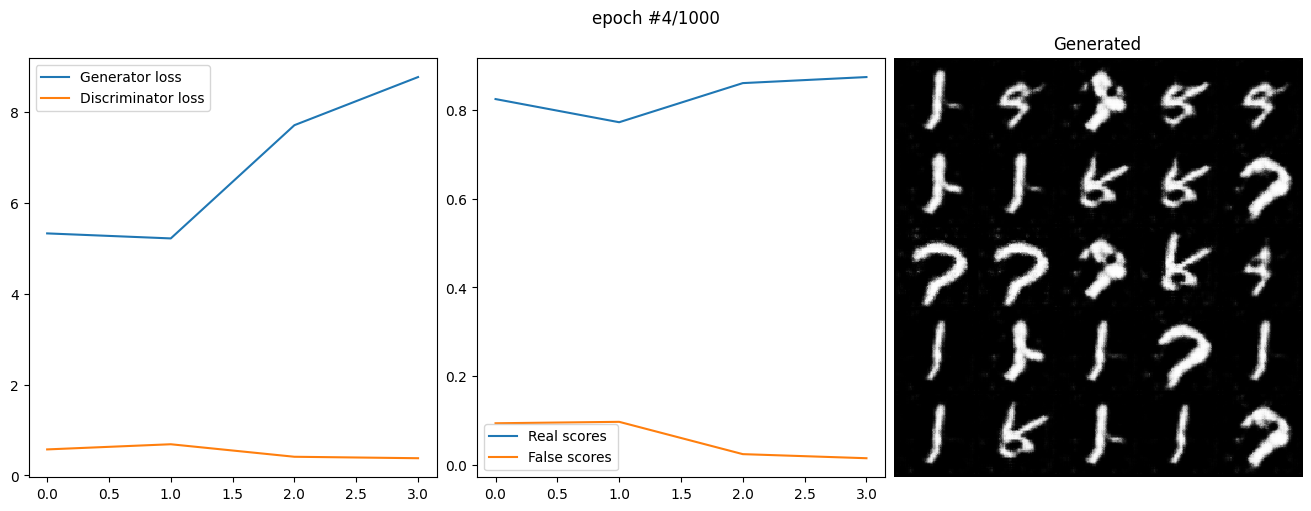

batch iterations:   0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
losses_g, losses_d, real_scores, fake_scores = train_gan(
    model=model,
    loader=train_loader,
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=1000,
    device=DEVICE,
    log_step=1
)

---

### 2.3 Mode collapse

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*iYSy1UlFtGcpWRFquJiqPA.png)

Mode collapse in GANs occurs when the generator learns to fool the discriminator by generating examples solely from one specific class, disregarding the full diversity of the training dataset.

Solutions are another GANs architectures:
- [Wasserstein GAN](https://arxiv.org/abs/1701.07875)(WGAN) modifies loss with Wasserstein distance. Such gradients enables better convergence, making WGANs effective in handling mode collapse and generating more diverse and realistic samples
- [Unrolled GAN](https://arxiv.org/pdf/1611.02163)(UGAN) using a generator loss function that takes into account not only the current discriminator’s classifications but also the outputs of future discriminator versions

---

# 3. Generation quality assessment

## 3.1 Inception Score

**Aim**: see how diverse samples are

### Idea
Let's see how much classes our generative model is able to generate

![image](https://drive.google.com/uc?export=view&id=1KeAlvclwy8qcN95RR_AGEOKtA8V2n8do)
![image](https://drive.google.com/uc?export=view&id=1EMiTbI7K4WPsEZc0DQKWzOyLC4d4X2cf)

### How it works
We compare each samples classes with averaged (marginal) one. If each sample's distribution differs from common (marginal) one, then it differs from others.

![image](https://drive.google.com/uc?export=view&id=1vMr5iaASkljc0yOXigSTZGS4WX14XEw2)

Here KL divergence is used to calculate the distance

Higher inception score means your model can generate distinct images

---

## 3.2 Frechet Inception Distance (FID)

**Idea**: compare distributions of real and generated samples

**Algorithm**:
1. Get samples embeddings from intermediate layers of neural network pre-trained on some external dataset
2. Approximate embeddings of real and generated samples by gaussians $\mathcal{N}(\mu_1, \Sigma_1)$ and $\mathcal{N}(\mu_2, \Sigma_2)$ respectively
3. Calclulate Frecher Distance = $\|\mu_1 – \mu_2\|^2 + Tr(\Sigma_1 + \Sigma_2 - 2 * (\Sigma_1*\Sigma_2)^{\frac{1}{2}})$.

Lower FID score corresponds to more realistic reconstructions

---

## 3.3 Learned Perceptual Image Similarity(LPIPS)

![](https://blog.paperspace.com/content/images/size/w1600/2023/01/Screen_Shot_2023-01-05_at_4.31.15_PM.png)

$$d_{LPIPS}(x,y)=\Sigma_l\frac{1}{H_lW_l}\Sigma_{i,j}||w_l\cdot(\hat{x}^l_{ij}-\hat{y}^l_{ij})||^2_2$$
where $\hat{x}^l_{ij}$ and $\hat{y}^l_{ij}$ denote the normalized feature vectors at layer $l$ and pixel $(i, j)$, $w_l$ contains weights for each of the features in layer $l$, and $\cdot$ multiplies the feature vectors at each pixel by the specifically learned weights

Lower LPIPS score corresponds to more realistic reconstructions

## Metrics summary

![](https://miro.medium.com/max/875/0*GHvXKp6DQPAHGdqH)



### Comparison

| Metric | IS | FID | LPIPS |
|:-:|:-:|:-:|:-:|
| Aim | show *how variate* generated images are | show *how close* generated images to real ones are | ~ |
| Which distributions are compared? | predicted class distributions (marginal vs. sample's one) | Two continuous gaussian distributions (real vs. generated one) | ~ |
| Which data is used? | Generated only | Generated and real | ~ |
| Which distance is used?           | $\mathbb{D_{KL}}$ | Frechet distance  | scaled $L_2$ |
| backbone network           | Inception v3 | Inception v3 or similar(eg. ResNet)  | VGG |

---

# Recap

We discussed how to:
1. **AE**s:
    - work with autoencoders latent space
    - motivation and derivation of $\mathbb{D}_{KL}$
    - achieve latent space regularity with **VAE**s
    - interpolate between **VAE** latent space to generate variations of some class OR to trace path between the two
2. **GAN**s:
    - upsample avoiding checkerboard artifacts
    - achieve training stability
    
3. **Generation QA**:
    - estimate perceptual quality of generated images

___

# Further reading

Autoencoders:
- [StackOverflow](https://stackoverflow.com/questions/60533150/what-is-the-difference-between-sample-and-rsample): discussion on `.sample()` vs `.rsample()`
- [PyTorch doc](https://pytorch.org/docs/stable/distributions.html): implementation of different distributions, supporting reparametrization trick
- [Medium](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73): understanding VAE
- [lilianweng blog](https://lilianweng.github.io/posts/2018-08-12-vae/): autoencoders family
- [alexalemi blog](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained) - KL divergence explained

GANs:
- [arxiv](https://arxiv.org/pdf/1701.00160): GAN author's tutorial
- [Medium](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628): GAN training heuristics
- [GitHub](https://github.com/soumith/ganhacks) ganhacks(more info in heuristics), MUST READ
- [PyTorch doc](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html): PyTorch DCGAN tutorial
- [GitHub](https://github.com/nashory/gans-awesome-applicationshttps://github.com/nashory/gans-awesome-applications): GANs application
- [Reddit](https://www.reddit.com/r/MachineLearning/comments/9t712f/dwhy_are_images_created_by_gan_sharper_than/): why images recostructed with GANs look sharper than VAE

Generation QA:
- [arxiv](https://arxiv.org/abs/1606.03498): IS original paper
- [arxiv](https://arxiv.org/abs/1706.08500): FID original paper: original paper
- [GitHub.io](https://richzhang.github.io/PerceptualSimilarity/): LPIPS original paper
# References
- [Stanley Chan tutotial on VAE and diffusion models](https://arxiv.org/abs/2403.18103)